# Generating Transmission Spectra with TRIDENT


An example notebook showing how to run POSEIDON's forward model, TRIDENT, to generate a 1D transmission spectrum.

### Stellar and Planet Properties

First, let's provide properties of the host star.

In [1]:
from POSEIDON.core import create_star
from POSEIDON.constants import R_Sun

#***** Define stellar properties *****#

R_s = 0.87*R_Sun      # Stellar radius (m)
T_s = 5079.0          # Stellar effective temperature (K)
Met_s = -0.04         # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s)

Now we can create our first planet!

We begin by defining the key physical properties of the planet --- you can find these on [exo.MAST](https://exo.mast.stsci.edu/).

The user can provide either $M_p$ or $g_p$. If only $M_p$ is provided, POSEIDON calculates the value of $g_p$ corresponding to the observed radius. Since the observational error on planetary gravity is usually less than planetary mass, $g_p$ is the preferred quantity in POSEIDON.

In [2]:
from POSEIDON.core import create_planet
from POSEIDON.constants import R_J, M_J

#***** Define planet properties *****#

planet_name = 'HAT-P-26b'  # Planet name used for plots, output files etc.

R_p = 0.63*R_J      # Planetary radius (m)
T_eq = 1043.8       # Equilibrium temperature (K)
M_p = 0.07*M_J      # Mass of planet (kg)
g_p = 4.3712        # Gravitational field of planet (m/s^2)

# Create the planet object
planet = create_planet(planet_name, R_p, T_eq, Mass = M_p, gravity = g_p)

### Defining a Model

Now we are ready to define the model settings. By 'model', we mean a family of parameters that define the permitted range of states for the planetary atmosphere. 

For example, one model could be a cloud-free giant planet atmosphere containing H<sub>2</sub>O and CH<sub>4</sub> with an isothermal temperature profile. Let's define that example model now. 

In [3]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Simple_model'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']          # H2 + He comprises the bulk atmosphere
param_species = ['H2O', 'CH4']   # The trace gases are Na, K, and H2O

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')

POSEIDON includes many other model settings, including options for 1D, 2D, and 3D atmospheres. Many of these more advanced settings are covered in later tutorials in this guide.

### Load Opacities

With our model defined, the next step is to read in the cross sections / opacity data required for this model.

POSEIDON's opacity database includes high spectral resolution line-by-line cross sections ($\Delta \tilde{\nu} = 0.01$ cm<sup>-1</sup>, equivalent to $R = \lambda / \Delta \lambda = 10^6$ at 1 micron) for over 50 chemical species, precomputed on a grid of 162 pressure-temperature points. In addition to these cross sections, absorption from pair processes — collision-induced absorption (CIA) and free-free absorption — and Rayleigh scattering is automatically included. The current version of the POSEIDON opacity database is described **HERE (ADD LINK)**.

POSEIDON can handle cross sections in two different ways:

1. *Opacity sampling*: for interpreting low spectral resolution data (e.g. space-based observations), the user specifies a moderate resolution wavelength grid (e.g. $R = 5000$) and a temperature and pressure range encompassing the model. POSEIDON then interpolates the high resolution cross sections from the opacity database to store moderate resolution cross sections in memory for the chemical species required by the model. This process typically takes about a minute (depending on the number of chemical species in the model) and requires a few GB of RAM. However, this only needs to be done once for a given model (hence speeding up spectra computations during retrievals).

2. *Line-by-line*: for interpreting high spectral resolution data (e.g. ground-based spectrographs), cross sections can be used at the native resolution of the POSEIDON opacity database. In this mode, POSEIDON does not pre-interpolate and store cross sections in memory. Rather, the opacity database is directly interpolated according to the pressures and temperatures in each layer of an atmosphere.

Let's now initialise the opacities for our example giant planet atmosphere. We'll use opacity sampling at a spectral resolution of $R = 5000$ (a good rule of thumb for opacity sampling is to compute models at $\sim 100 \times$ higher resolution than the data you intend to compare to after binning down the model).

In [4]:
from POSEIDON.core import read_opacities, wl_grid_constant_R
import numpy as np

#***** Wavelength grid *****#
 
wl_min = 0.6      # Minimum wavelength (um)
wl_max = 5.3      # Maximum wavelength (um)
R = 5000          # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 400     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2000    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
H2O done
CH4 done
Opacity pre-interpolation complete.


### Specify a Planetary Atmosphere

Now we are ready to specify the properties of the atmosphere for which we want to compute a spectrum.

To generate our atmosphere, we need to provide the following information:

1. A pressure grid for the atmosphere.
2. A reference pressure and the corresponding planet radius.
3. Parameters defining the pressure-temperature (P-T profile).
4. Parameters defining the mixing ratios.
5. Parameters defining any clouds / aerosols.
6. Parameters defining the atmospheric geometry (2D and 3D models only).

We can check the necessary parameters for the model we defined earlier by querying the model object.

In [5]:
print(model['PT_param_names'])
print(model['X_param_names'])
print(model['cloud_param_names'])
print(model['geometry_param_names'])

['T']
['log_H2O' 'log_CH4']
[]
[]


You can also print all the model parameters in one go.

In [6]:
# Check the free parameters defining this model
print("Free parameters: " + str(model['param_names']))

['T' 'R_p_ref' 'log_H2O' 'log_CH4']


We see that our model needs to know the (isothermal) atmospheric temperature, the reference planet radius, and the log-mixing ratios of H$_2O and CH$_4$. The remainder of the atmosphere will be automatically filled with the bulk gas we specified (in our case, H$_2$ and He with an assumed solar ratio). Since we chose a 1D cloud-free model, we don't need to provide cloud or geometry parameters.

Let's specify the required parameters now and generate our atmosphere.

In [7]:
from POSEIDON.core import make_atmosphere

# Specify the pressure grid of the atmosphere
P_min = 1.0e-7    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([1000])                # T (K)
log_X_params = np.array([[-3.3, -5.0]])     # log(H2O), log(CH4)

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, R_p_ref, P, P_ref, 
                             PT_params, log_X_params)

We can now plot our atmosphere, temperature profile, and mixing ratio profiles.

/home/rmacdonald/code/POSEIDON_public/POSEIDON/visuals.py:339: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


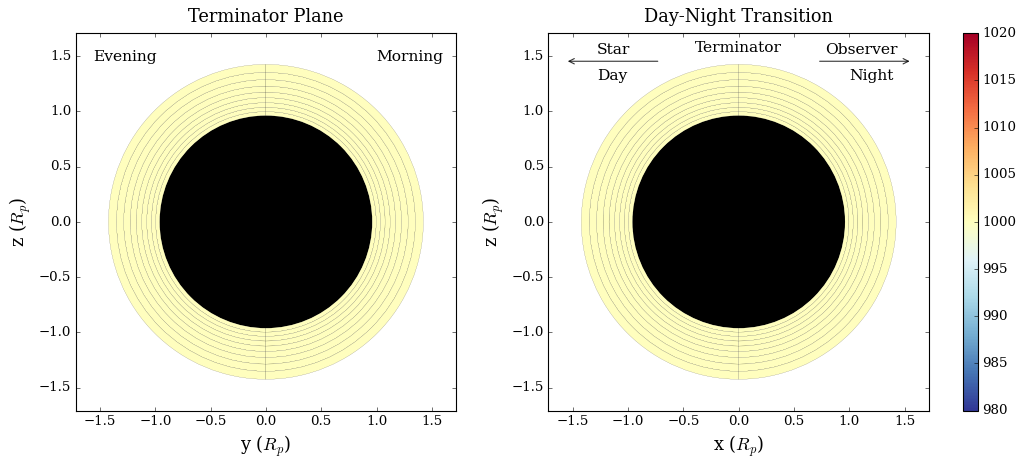

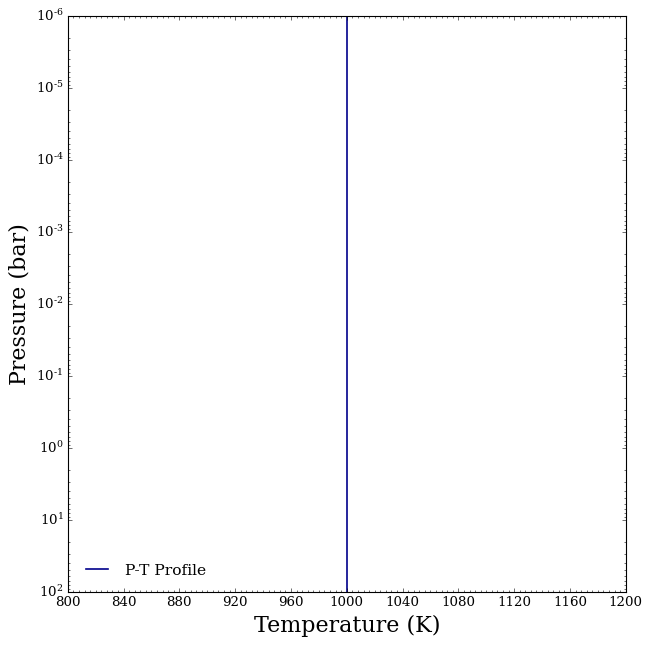

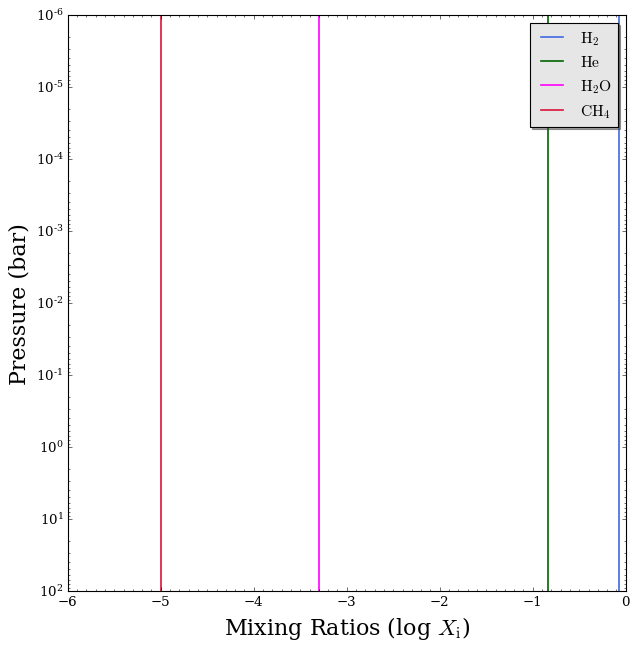

In [8]:
from POSEIDON.visuals import plot_geometry, plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_geom = plot_geometry(planet, star, model, atmosphere)
fig_PT = plot_PT(planet, model, atmosphere)  
fig_chem = plot_chem(planet, model, atmosphere)

And like magic, our model planet has come to life! 

These figures have been automatically saved in the 'POSEIDON_output' directory, which is by created by default in the same directory where you ran this python script. You can further manipulate them using the matplotlib figure objects returned by the functions. 

### Computing Transmission Spectra

We are finally ready to generate the transmission spectrum of our planet! 

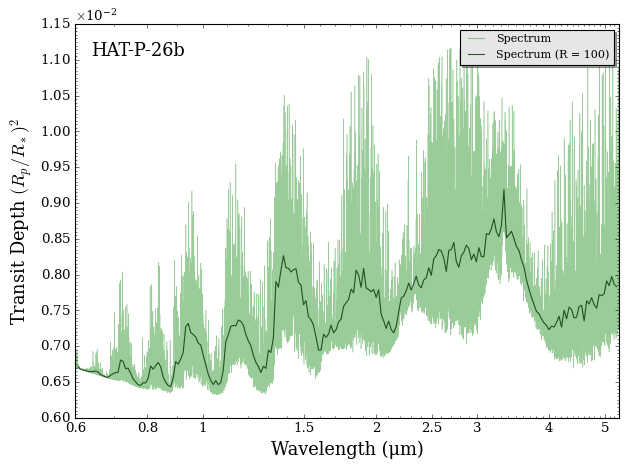

In [9]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate our first transmission spectrum
spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')

# Add the spectrum we want to plot to an empty spectra plot collection
spectra = plot_collection(spectrum, wl, collection = [])

# Produce figure and save to file
fig = plot_spectra(spectra, planet, model, R_to_bin = 100)


Notice how we added our spectrum to an empty 'spectrum collection'? This provides a convenient way to compare multiple spectra on the same figure. For example, let's add a transmission spectrum for a copy of our atmosphere with CH$_4$ removed.

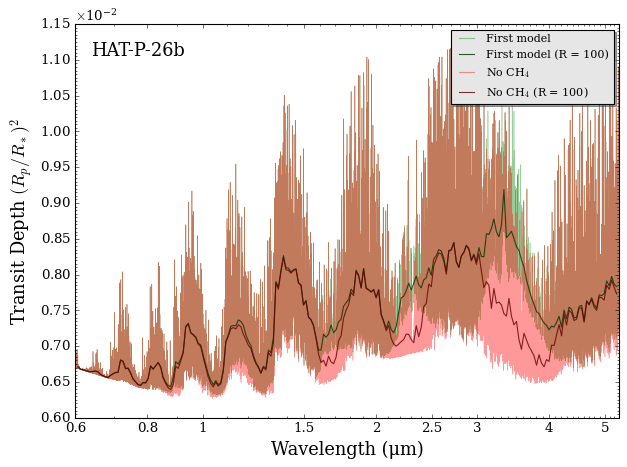

In [10]:
# Define new mixing ratio array with a low CH4 abundance
log_X_params_no_CH4 = np.array([[-3.3, -50.0]])  # log(H2O), log(CH4)

# Create a new atmosphere without CH4
atmosphere_no_CH4 = make_atmosphere(planet, model, R_p_ref, P, P_ref, 
                                    PT_params, log_X_params_no_CH4)

# Generate the new transmission spectrum
spectrum_no_CH4 = compute_spectrum(planet, star, model, atmosphere_no_CH4, 
                                   opac, wl, spectrum_type = 'transmission')

# Add the spectrum we want to plot to our existing plot collection
spectra = plot_collection(spectrum_no_CH4, wl, collection = spectra) 

# Produce figure
fig = plot_spectra(spectra, planet, model, R_to_bin = 100,
                   spectra_labels = ['First model', 'No CH$_4$'])


### High-resolution Transmission Spectra

Now that we've seen how to make low spectral resolution transmission spectra, let's make a high spectral resolution line-by-line transmission spectrum for the same atmosphere.

First, we need to change the opacity object we're working with to be in a line-by-line configuration.

In [11]:
from POSEIDON.core import wl_grid_line_by_line

#***** Wavelength grid *****#
 
wl_min = 0.6      # Minimum wavelength (um)
wl_max = 5.3      # Maximum wavelength (um)    

wl_high_res = wl_grid_line_by_line(wl_min, wl_max)

#***** Read opacity data *****#

opacity_treatment = 'line_by_line'

# Prepare high-resolution opacity data
opac_high_res = read_opacities(model, wl_high_res, opacity_treatment)

Now we can generate a high resolution line-by-line spectrum for our model atmosphere.


<div class="alert alert-warning">

  **Warning:**

  Line-by-line models are *very* resource intensive. Please ensure you have ~ 8 GB of free RAM before running the cell below, which should take about two minutes.

</div>


Reading in cross sections in line-by-line mode...
H2-H2 done
H2-He done
H2-CH4 done
H2O done
CH4 done
Finished producing extinction coefficients


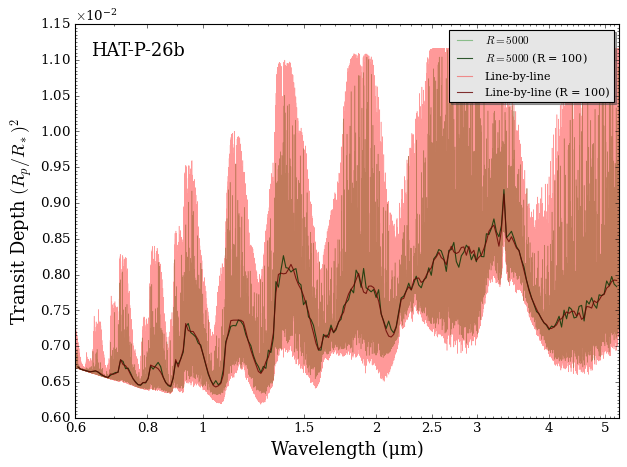

In [12]:
# Generate the high-resolution spectrum
spectrum_high_res = compute_spectrum(planet, star, model, atmosphere, 
                                     opac_high_res, wl_high_res,
                                     spectrum_type = 'transmission')

# Add both the low-res and high-res spectra to a new plot collection
spectra = plot_collection(spectrum, wl, collection = [])
spectra = plot_collection(spectrum_high_res, wl_high_res, collection = spectra) 

# Produce figure
fig = plot_spectra(spectra, planet, model, R_to_bin = 100,
                   spectra_labels = ['$R = 5000$', 'Line-by-line'])

Notice how the spectra from line-by-line and opacity sampling look similar when binned down to $R = 100$? The jagged appearance of the opacity sampling spectrum is essentially statistical noise scattered about the 'true' line-by-line spectrum. However, the sampling noise decreases as one increases the spectral resolution the cross sections are sampled at (here, $R = 5000$). Ultimately, the advantage of opacity sampling is the dramatic decrease in runtime compared to full line-by-line computations (hence POSEIDON uses opacity sampling in retrievals).

Congratulations! Now that you've generated three transmission spectra, in the next tutorial we'll cover how to generate millions of spectra to fit an observed spectrum (i.e. atmospheric retrieval).